# Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

**For sure it is a computer vision model.**

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

**(5->1, 5->1)**

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

**accuracy = acc1 + acc2 / 2**
**where acc1 = (correct1/total) and acc2 = (correct2/total)**

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

# Data preparation

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.nn import fractional_max_pool
from keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.callbacks import Callback
from keras.saving import load_model, save_model, save_weights

2025-01-11 09:18:17.640690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736615897.661267   17527 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736615897.667286   17527 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 09:18:17.686517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, 32, 32, 3)
assert cifar10_x_test.shape == (10000, 32, 32, 3)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

# Split the training set into training and validation sets
cifar10_x_train, cifar10_x_val, cifar10_y_train, cifar10_y_val = train_test_split(
    cifar10_x_train, cifar10_y_train, test_size=0.1
)

# First classifier: "airplane", "automobile", "bird", "cat", "deer"
# Second classifier: "dog", "frog", "horse", "ship", "truck"
# IDEA: extract the features with a CNN backbone and feed them to two seperate FCN classifiers. How about backpropogation?
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Normalizing to range (0,1)
cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_val = (cifar10_x_val / 255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

Let us split the images in two groups, according to their label.

In [3]:
cond_1 = cifar10_y_train[:,0] < 5
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= 5
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_val = cifar10_y_val[:,0] < 5
cifar10_x_val_1 = cifar10_x_val[cond_1_val]
cifar10_y_val_1 = cifar10_y_val[cond_1_val]

cond_2_val = cifar10_y_val[:,0] >= 5
cifar10_x_val_2 = cifar10_x_val[cond_2_val]
cifar10_y_val_2 = cifar10_y_val[cond_2_val]

cond_1_test = cifar10_y_test[:,0] < 5
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= 5
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

print(cifar10_x_train_1.shape, cifar10_y_train_1.shape)
print(cifar10_x_train_2.shape, cifar10_y_train_2.shape)
print(cifar10_x_val_1.shape, cifar10_y_val_1.shape)
print(cifar10_x_val_2.shape, cifar10_y_val_2.shape)
print(cifar10_x_test_1.shape, cifar10_y_test_1.shape)
print(cifar10_x_test_2.shape, cifar10_y_test_2.shape)

(22515, 32, 32, 3) (22515, 1)
(22485, 32, 32, 3) (22485, 1)
(2485, 32, 32, 3) (2485, 1)
(2515, 32, 32, 3) (2515, 1)
(5000, 32, 32, 3) (5000, 1)
(5000, 32, 32, 3) (5000, 1)


Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

**Model input: (B x X1\*X2)**
**Model output: (B x Y1 x Y2)**

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format.

In [4]:
batchsize = 64

def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  # Convert the integer labels into one hot encoded vectors for cross entropy loss
  # Careful: since there are two different sets of labels, I need to code two seperate outputs with seperate cross entropy losses
  # Keras (TF) can handle this with: model = models.Model(inputs=merged_input_image, outputs=[output1, output2])
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=5)
  Y2_cat = tf.keras.utils.to_categorical(Y2-5, num_classes=5)

  while True:
    # Random image selections
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    # Average image production
    x_data = (X1[num1] + X2[num2]) / 2.0
    # Dictionary for y_data with keys matching the model
    y_data = {'output1': Y1_cat[num1], 'output2': Y2_cat[num2]}
    # Convert numpy to tf tensor
    yield tf.convert_to_tensor(x_data), y_data

traingen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batchsize)
valgen = datagenerator(cifar10_x_val_1,cifar10_x_val_2,cifar10_y_val_1,cifar10_y_val_2,batchsize)
smalltestgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1000)


Let us instantiate a generator on Cifar10 with batchsize=1, and let's see its behaviour.

In [11]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

I0000 00:00:1736540896.974210    4689 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:0a:00.0, compute capability: 8.9


first: cat, second = horse


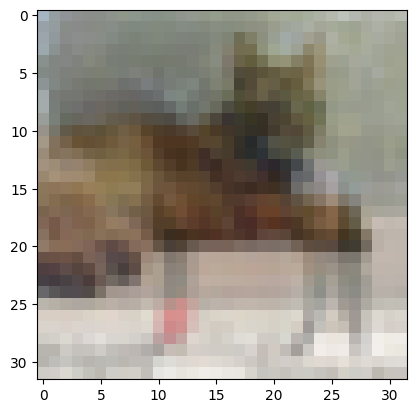

In [12]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y['output1'][0])],classes[np.argmax(y['output2'][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])

# Model Evaluation

Let us define first of all the test generator.

In [ ]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)


eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


I0000 00:00:1736615818.500797   16445 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13105 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:0a:00.0, compute capability: 8.9


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [9]:
def random_model(x):
  #the random model ignores the input x and return a pair of random classes
  # 10,000 examples in a 2 column array between 0 and 4 inclusive
  return(np.random.randint(0,5,(10000,2)))

In [10]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = random_guesses[:,0] == np.argmax(eval_samples_y['output1'],axis=1)
  correct_guesses_2 = random_guesses[:,1] == np.argmax(eval_samples_y['output2'],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [11]:
eval_model(random_model)

0.20655

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [12]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(random_model))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mean accuracy =  0.199285
standard deviation =  0.0022481158777963414


# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!



First I googled CIFAR-10 best accuracy and I fell upon a reddit post about a person trying to train it as fast as possible, [here](https://github.com/tysam-code/hlb-CIFAR10). Since I am not interested in light speed CIFAR-10, I googled only CIFAR-10 and arrived to the main website for this [dataset](https://www.cs.toronto.edu/~kriz/cifar.html). From there, I found a non-working link to Rodrigo Benenson since github.com has been deprecated and is now github.io, changing this and selecting "who is the best in CIFAR-10 ?" brought me to the [world rankings](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130). Now I will read these papers in order. The first is [Fractional Max Pooling](https://arxiv.org/abs/1412.6071), with an accuracy of 96.53%. As I read this, I think, is my task the same? As a human, can I learn to distinguish the two classes? For sure, I will have to use the generator to see.


In [13]:
# Define my fractional pooling model

class FMP(Model):
    def __init__(self):
        super(FMP, self).__init__()
        # Input
        #self.input_layer = layers.InputLayer(shape=(32, 32, 3))  # For CIFAR-10 images

        # Four convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(10, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(20, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(30, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(40, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(50, (1, 1), activation=LeakyReLU())

        # Three fractional max pooling layers
        self.pooling_ratio1 = [1.0, 3/2, 3/2, 1.0]
        self.pooling_ratio2 = [1.0, 6/4, 6/4, 1.0]
        self.pooling_ratio3 = [1.0, 10/7, 10/7, 1.0]

        # Linearly increasing dropout in the hidden layers
        #self.dropout1 = layers.Dropout(0.0)  # 0% dropout in the first hidden layer
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier
        self.fc1 = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Input
        #x = self.input_layer(inputs)

        # Feature Extractor
        x = self.conv1(inputs)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True)
        x = self.conv2(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True)
        x = self.conv3(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True)
        x = self.conv4(x)
        x = self.conv5(x)

        # Classifier
        x = layers.Flatten()(x)
        x = self.dropout(x)
        x = self.fc1(x)  # CIFAR-10

        return x

K.clear_session()
model = FMP()
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │        18,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,280 (110.47 KB)

 Trainable params: 28,280 (110.47 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
Y_cat_train = tf.keras.utils.to_categorical(cifar10_y_train, num_classes=10)
Y_cat_test = tf.keras.utils.to_categorical(cifar10_y_test, num_classes=10)
print(cifar10_x_train.shape)
print(Y_cat_train.shape)

(45000, 32, 32, 3)
(45000, 10)


In [ ]:
history = model.fit(x=cifar10_x_train, y=Y_cat_train, epochs=1, batch_size=2048)

22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 549ms/step - accuracy: 0.1475 - loss: 2.2588


In [ ]:
# Evaluate
def evaluate(model, x, y):
    loss, accuracy = model.evaluate(x, y)
    print(f"{model.name} Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")
    return accuracy

evaluate(model, x=cifar10_x_test, y=Y_cat_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2547 - loss: 2.0465
fmp Loss: 2.0488, Accuracy: 25.46%


0.25459998846054077

Implementing this, I feel like the convolutional layers would benefit from being more complex and so I use this [person's](https://github.com/WingsBrokenAngel/fractional_max_pooling_and_recurrent_convolutional_neural_network) filters.

In [17]:
class FMP1(Model):
    def __init__(self, FILTERS):
        super(FMP1, self).__init__()
        # Parameters
        self.filters = FILTERS

        # Four convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(10*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(20*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(30*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(40*FILTERS, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(50*FILTERS, (1, 1), activation=LeakyReLU())

        # Three fractional max pooling layers
        self.pooling_ratio1 = [1.0, 3/2, 3/2, 1.0]
        self.pooling_ratio2 = [1.0, 6/4, 6/4, 1.0]
        self.pooling_ratio3 = [1.0, 10/7, 10/7, 1.0]

        # Linearly increasing dropout in the hidden layers
        #self.dropout1 = layers.Dropout(0.0)  # 0% dropout in the first hidden layer
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier
        self.fc1 = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Input
        #x = self.input_layer(inputs)

        # Feature Extractor
        x = self.conv1(inputs)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True)
        x = self.conv2(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True)
        x = self.conv3(x)
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True)
        x = self.conv4(x)
        x = self.conv5(x)

        # Classifier
        x = layers.Flatten()(x)
        x = self.dropout(x)
        x = self.fc1(x)  # CIFAR-10

        return x

#K.clear_session()
model = FMP1(FILTERS=3)
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ ?                      │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        21,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │        43,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │        18,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │        54,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 144,820 (565.70 KB)

 Trainable params: 144,820 (565.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x=cifar10_x_train, y=Y_cat_train, epochs=1, batch_size=2048)

22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1188 - loss: 2.5421


In [19]:
evaluate(model, x=cifar10_x_test, y=Y_cat_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2040 - loss: 2.1521
fmp1 Loss: 2.1532, Accuracy: 20.36%


0.20360000431537628

I decide to implement a network as similar as possible, now that I understand the architecture better!

In [20]:
class FMP2(Model):
    def __init__(self):
        super(FMP2, self).__init__()
        # Input layer size 36x36

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU()) # 36x36 # comment left here to show how the first time I calculated them wrong, both by thinking the input is 36 when it is 32 and forgetting conv takes 1 
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU()) # 25x25
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU()) # 18x18
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU()) # 13x13
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU()) # 9x9
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 6x6

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Classifier 
        self.fc = layers.Dense(10, activation='softmax')  # CIFAR-10 (10 classes)

    def call(self, inputs):
        # Feature Extractor
        x = self.conv1(inputs) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        # IDEA: dropout here at 25%
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        x = self.fc(x)  # CIFAR-10

        return x

In [21]:
K.clear_session()
model = FMP2()
model.build(input_shape=(None, 32, 32, 3))  # Adjust if needed
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
Y_cat_train = tf.keras.utils.to_categorical(cifar10_y_train, num_classes=10)

history = model.fit(x=cifar10_x_train, y=Y_cat_train, epochs=1, batch_size=1000)

45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.1003 - loss: 14.8851


In [23]:
evaluate(model, x=cifar10_x_test, y=Y_cat_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.1286 - loss: 2.3659
fmp2 Loss: 2.3636, Accuracy: 12.55%


0.12549999356269836

Without checkpoints or early stop, the model clearly overfit!

Now I realize I forgot to read section 4.4 and implement that network! However, before, I try to move my network from the proxy task to the real one by adding a second classifier head.

In [226]:
@keras.saving.register_keras_serializable()
class FMP3(Model):
    def __init__(self):
        super(FMP3, self).__init__()
        # Input layer size 32x32

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU())
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU())

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Two Classifiers 
        self.fc1 = layers.Dense(5, activation='softmax', name='output1')  # First half
        self.fc2 = layers.Dense(5, activation='softmax', name='output2')  # Second half

    def call(self, inputs):
        # Feature Extractor
        x = self.conv1(inputs) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        # IDEA: dropout here at 25%
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        output1 = self.fc1(x)  # First half
        output2 = self.fc2(x)  # Second half

        return {'output1': output1, 'output2': output2}
    
    def get_config(self):
        # Serialize the configuration of the model
        config = super(FMP3, self).get_config()
        config.update({
            'conv1': self.conv1.get_config(),
            'conv2': self.conv2.get_config(),
            'conv3': self.conv3.get_config(),
            'conv4': self.conv4.get_config(),
            'conv5': self.conv5.get_config(),
            'conv6': self.conv6.get_config(),
            'conv7': self.conv7.get_config(),
            'conv8': self.conv8.get_config(),
            'dropout': self.dropout.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
            'pooling_ratios': [
                self.pooling_ratio1,
                self.pooling_ratio2,
                self.pooling_ratio3,
                self.pooling_ratio4,
                self.pooling_ratio5,
                self.pooling_ratio6
            ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls()

In [227]:
K.clear_session()
model = FMP3()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output1 (Dense)                 │ ?                      │           965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output2 (Dense)                 │ ?                      │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

The [answer](https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary) with 39 upvotes explains why this summary is a bit strange (Keras subclasses Model).

In [104]:
# Generate random dummy data (e.g., 100 samples, 32x32 RGB images)
X_train = np.random.randn(100, 32, 32, 3).astype(np.float32)
y_train1 = np.random.randint(0, 5, 100)  # Random labels for output 1
y_train2 = np.random.randint(0, 5, 100)  # Random labels for output 2

# Convert labels to one-hot encoding
y_train1 = tf.keras.utils.to_categorical(y_train1, 5)
y_train2 = tf.keras.utils.to_categorical(y_train2, 5)

# Train the model directly using the data (no generator)
history = model.fit(X_train, {'output1': y_train1, 'output2':y_train2}, epochs=5, batch_size=32)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 3.2640 - output1_accuracy: 0.1915 - output2_accuracy: 0.1730
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 3.1825 - output1_accuracy: 0.3210 - output2_accuracy: 0.1944
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 3.2185 - output1_accuracy: 0.2629 - output2_accuracy: 0.2418
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 3.2213 - output1_accuracy: 0.3148 - output2_accuracy: 0.2314
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.1669 - output1_accuracy: 0.3013 - output2_accuracy: 0.2873


I had a long and painful time figuring out why my generator was not working with fit. Finally I understood that the output of the generator must have a dictionary whose entries match those of the model when compiled!
https://stackoverflow.com/questions/44036971/multiple-outputs-in-keras
Before that I went down a rabbit hole with older versions of keras which require [fit_generator](https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/) because of a stack exchange [post](https://datascience.stackexchange.com/questions/67266/how-to-write-a-generator-for-keras-fit-generator).
I read the keras documentation and confirmed that generators are in fact, [well supported](https://keras.io/api/models/model_training_apis/). This hinted to me that the generator would probably work for a simpler single input, single output model.
I researched how to create [my own data generator class](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) that inherits from Keras Sequences.

In [105]:
history = model.fit(traingen, epochs=1, steps_per_epoch=len(cifar10_x_train)//batchsize)

703/703 ━━━━━━━━━━━━━━━━━━━━ 70s 98ms/step - loss: 3.0398 - output1_accuracy: 0.2971 - output2_accuracy: 0.3073


Start training with [checkpoints](https://keras.io/api/callbacks/model_checkpoint/)! Its easy! Also add early stopping! I look at my history to verify the names of my scores.

In [106]:
history.history

{'loss': [2.8955788612365723],
 'output1_accuracy': [0.34895092248916626],
 'output2_accuracy': [0.37237730622291565]}

I implement a custom model callback to save the model weights when the average accuracy improves. 

In [14]:
# Custom callback which does not use loss as a proxy!
class MeanAccModelCheckpoint(Callback):
    def __init__(self, filepath, monitor1='output1_accuracy', monitor2='output2_accuracy', mode='max', verbose=1):
        super(MeanAccModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor1 = monitor1
        self.monitor2 = monitor2
        self.mode = mode
        self.verbose = verbose
        self.best_score = -float('inf') if mode == 'max' else float('inf')

    # Called at the end of an epoch during training
    def on_epoch_end(self, epoch, logs=None):
        acc1 = logs.get(self.monitor1)
        acc2 = logs.get(self.monitor2)

        # Compute the average accuracy
        avg_accuracy = (acc1 + acc2) / 2 if acc1 is not None and acc2 is not None else None

        if avg_accuracy is not None:
            if (self.mode == 'max' and avg_accuracy > self.best_score) or \
               (self.mode == 'min' and avg_accuracy < self.best_score):
                # Update the best score
                self.best_score = avg_accuracy
                
                # Format the filepath
                save_path = self.filepath.format(
                    output1_accuracy=acc1,
                    output2_accuracy=acc2,
                    epoch=epoch + 1,  # Epoch is zero-indexed
                    loss=logs.get('loss')
                )
                
                # Save the model
                if self.verbose:
                    print(f"\nEpoch {epoch + 1}: Average accuracy improved to {avg_accuracy:.4f}, saving model to {save_path}")
                self.model.save(save_path)
            elif self.verbose:
                print(f"\nEpoch {epoch + 1}: Average accuracy did not improve (current: {avg_accuracy:.4f}, best: {self.best_score:.4f})")


I want to train more, but it bothers me that I am saving models based on loss, so lets write a custom callback which matches our evaluation criteria! I follow this page on [Callbacks](https://keras.io/guides/writing_your_own_callbacks/) and decide I also wish to employ the Tensorboard callback.

In [112]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./FMP3/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

In [113]:
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=2
)

Epoch 1/100

Epoch 1: Average accuracy improved to 0.6707, saving model to ./FMP3/0.63-0.71-epoch01-loss1.68.keras
703/703 - 69s - 97ms/step - loss: 1.6830 - output1_accuracy: 0.6299 - output2_accuracy: 0.7209 - val_loss: 1.7101 - val_output1_accuracy: 0.6340 - val_output2_accuracy: 0.7073
Epoch 2/100

Epoch 2: Average accuracy did not improve (current: 0.6627, best: 0.6707)
703/703 - 68s - 97ms/step - loss: 1.6612 - output1_accuracy: 0.6377 - output2_accuracy: 0.7221 - val_loss: 1.7644 - val_output1_accuracy: 0.6196 - val_output2_accuracy: 0.7057
Epoch 3/100

Epoch 3: Average accuracy improved to 0.6812, saving model to ./FMP3/0.64-0.72-epoch03-loss1.67.keras
703/703 - 69s - 98ms/step - loss: 1.6667 - output1_accuracy: 0.6369 - output2_accuracy: 0.7217 - val_loss: 1.6689 - val_output1_accuracy: 0.6390 - val_output2_accuracy: 0.7234
Epoch 4/100

Epoch 4: Average accuracy did not improve (current: 0.6718, best: 0.6812)
703/703 - 69s - 98ms/step - loss: 1.6482 - output1_accuracy: 0.6349 

Now to get a baseline, by evaluating this model according to the project prompt! As always with **tqdm** I first imported it directly, then remembered you have the import the module with the same name as the library. My evaluated model is fresh and initialized with the best trained weights.

While training, I think about data augmentation. I only have 50,000 test samples so if train 100 epochs I for sure am overfitting, need to research which augmentations are successful on CIFAR-10 to help the model generalize. My intuition says mirroring along the vertical axis should be safe. I do not think color augmentations are a good idea, since the colors are already degraded due to the random image merge. As I am thinking of this, I also realize a validation set would help me stop overfitting and allow me to test if data augmentation are helping, so I implement it (at the top of the notebook). Now I need to fit my model with validation accuracies and loss.

In [25]:
def evaluate_model(filepath, gen, repeat=1, steps=1):
    model = load_model(filepath)
    evaluation_results = []
    for i in tqdm(range(repeat)):
        loss, acc1, acc2 = model.evaluate(gen, batch_size=10000, steps=steps, verbose=False)
        evaluation_results.append(np.mean([acc1, acc2]))
    print("mean accuracy = ", np.mean(evaluation_results))
    print("standard deviation = ", np.std(evaluation_results))

#evaluate_model('./FMP3/0.67-0.74-epoch37-loss1.52.keras', testgen, repeat=10)

I am very happy with 70.9% accuracy, now I have to make sure saving and loading work.

In [118]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, acc2 = model.evaluate(testgen, batch_size=10000, steps=1, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:31<00:00,  3.15s/it]

mean accuracy =  0.6927750051021576
standard deviation =  0.006946627811636093


Implement my idea to include dropout at 25% after conv7

In [137]:
@keras.saving.register_keras_serializable()
class FMP4(Model):
    def __init__(self):
        super(FMP4, self).__init__()
        # Input layer size 32x32

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU())
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU())

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout1 = layers.Dropout(0.25)  # 50% dropout in the final hidden layer
        self.dropout2 = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Two Classifiers 
        self.fc1 = layers.Dense(5, activation='softmax')  # First half
        self.fc2 = layers.Dense(5, activation='softmax')  # Second half

    def call(self, inputs):
        # Feature Extractor
        x = self.conv1(inputs) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        x = self.dropout1(x) # IDEA: dropout here at 25%
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout2(x)
        output1 = self.fc1(x)  # First half
        output2 = self.fc2(x)  # Second half
        print(f"Final Output Shapes: output1={output1.shape}, output2={output2.shape}")

        return {'output1': output1, 'output2': output2}
    
    def get_config(self):
        # Serialize the configuration of the model
        config = super(FMP4, self).get_config()
        config.update({
            'conv1': self.conv1.get_config(),
            'conv2': self.conv2.get_config(),
            'conv3': self.conv3.get_config(),
            'conv4': self.conv4.get_config(),
            'conv5': self.conv5.get_config(),
            'conv6': self.conv6.get_config(),
            'conv7': self.conv7.get_config(),
            'conv8': self.conv8.get_config(),
            'dropout1': self.dropout1.get_config(),
            'dropout2': self.dropout2.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
            'pooling_ratios': [
                self.pooling_ratio1,
                self.pooling_ratio2,
                self.pooling_ratio3,
                self.pooling_ratio4,
                self.pooling_ratio5,
                self.pooling_ratio6
            ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls()

In [138]:
K.clear_session()
model = FMP4()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./FMP4/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

history = model.fit(
    traingen,           
    epochs=100,          
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen, 
    validation_steps=len(cifar10_x_val)//batchsize,  
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  
    verbose=2
)

Final Output Shapes: output1=(1, 5), output2=(1, 5)


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │           965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
Final Output Shapes: output1=(None, 5), output2=(None, 5)
Final Output Shapes: output1=(None, 5), output2=(None, 5)


KeyboardInterrupt: 

In [126]:
evaluate_model('./FMP4/0.65-0.73-epoch41-loss1.61.keras', testgen, repeat=10)

100%|██████████| 10/10 [00:30<00:00,  3.06s/it]

mean accuracy =  0.6774300068616868
standard deviation =  0.009838248775686023


Adding more dropout made things worse! This model taken from section 4.4, still needs data augmentation!

In [141]:
@keras.saving.register_keras_serializable()
class FMP5(Model):
    def __init__(self):
        super(FMP5, self).__init__()

        # Feature Extractor: Twelve convolutional layers with padding
        self.convs = [
            layers.Conv2D(160 + 160 * i, (2, 2), activation=LeakyReLU(), padding='same')
            for i in range(12)
        ]

        # Fractional Max Pooling Ratios (1.26)
        # self.pooling_ratios = [
        #     [1.0, 32/25, 32/25, 1.0],  
        #     [1.0, 25/20, 25/20, 1.0],
        #     [1.0, 20/16, 20/16, 1.0],
        #     [1.0, 16/13, 16/13, 1.0],
        #     [1.0, 13/10, 13/10, 1.0],
        #     [1.0, 10/8, 10/8, 1.0],
        #     [1.0, 8/6, 8/6, 1.0], 
        #     [1.0, 6/5, 6/5, 1.0],
        #     [1.0, 5/4, 5/4, 1.0],
        #     [1.0, 4/3, 4/3, 1.0],
        #     [1.0, 3/2, 3/2, 1.0],
        #     [1.0, 2/1, 2/1, 1.0],
        # ]

        self.pooling_ratios = [
            [1.0, 32/28, 32/28, 1.0],  # From 32x32 to ~28x28
            [1.0, 28/24, 28/24, 1.0],  # From ~28x28 to ~24x24
            [1.0, 24/20, 24/20, 1.0],  # From ~24x24 to ~20x20
            [1.0, 20/16, 20/16, 1.0],  # From ~20x20 to ~16x16
            [1.0, 16/13, 16/13, 1.0],  # From ~16x16 to ~13x13
            [1.0, 13/10, 13/10, 1.0],  # From ~13x13 to ~10x10
            [1.0, 10/8, 10/8, 1.0],    # From ~10x10 to ~8x8
            [1.0, 8/6, 8/6, 1.0],      # From ~8x8 to ~6x6
            [1.0, 6/5, 6/5, 1.0],      # From ~6x6 to ~5x5
            [1.0, 5/4, 5/4, 1.0],      # From ~5x5 to ~4x4
            [1.0, 4/3, 4/3, 1.0],      # From ~4x4 to ~3x3
            [1.0, 3/2, 3/2, 1.0],      # From ~3x3 to ~2x2
        ]

        # Final convolutional layers with padding
        self.conv = layers.Conv2D(1920, (1, 1), activation=LeakyReLU())

        # Dropout layers
        self.dropout = layers.Dropout(0.5)

        # Classifier
        self.fc1 = layers.Dense(5, activation='softmax')  # First half
        self.fc2 = layers.Dense(5, activation='softmax')  # Second half

    def call(self, inputs):
        # Track spatial dimensions starting from input size
        x = inputs

        for i in range(12):
            x = self.convs[i](x)  # Convolution with padding to maintain spatial size
            x, _, _ = fractional_max_pool(x, pooling_ratio=self.pooling_ratios[i], pseudo_random=True, overlapping=True)
            # print(f"After FMP{i + 1}: {x.shape}")

        # Final convolution and dropout
        x = self.conv(x)
        # print(f"After final conv: {x.shape}")
        x = self.dropout(x)

        # Two separate classifier heads
        x = layers.Flatten()(x)
        output1 = self.fc1(x)
        output2 = self.fc2(x)
        # print(f"Final Output Shapes: output1={output1.shape}, output2={output2.shape}")

        return {'output1': output1, 'output2': output2}

    def get_config(self):
        config = super(FMP5, self).get_config()
        config.update({
            'conv_layers': [conv.get_config() for conv in self.convs],
            'pooling_ratios': self.pooling_ratios,
            'conv': self.conv.get_config(),
            'dropout': self.dropout.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls()


In [142]:
K.clear_session()
model = FMP5()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./FMP5/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

history = model.fit(
    traingen,           
    epochs=100,          
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen, 
    validation_steps=len(cifar10_x_val)//batchsize,  
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  
    verbose=2
)

Model: "fmp5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │       614,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │     1,229,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │     2,048,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │     3,072,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │     4,301,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │     5,735,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │     7,374,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │     9,217,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │    11,265,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ ?                      │    13,518,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ ?                      │     3,688,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │         9,605 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │         9,605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,294,730 (237.64 MB)

 Trainable params: 62,294,730 (237.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


KeyboardInterrupt: 

Problem, fractional max pooling is only supported in CPU. Also, I read [this](https://stackoverflow.com/questions/39886715/fractional-max-pooling-in-tensorflow). Let's explore the second best CIFAR-10 paper.

In [148]:
import tensorflow as tf
from tensorflow.keras import layers, Model

@keras.saving.register_keras_serializable()
class ACNN(Model):
    def __init__(self):
        super(ACNN, self).__init__()
        
        # Layer Definitions
        self.conv1 = layers.Conv2D(320, (2, 2), strides=1, activation=LeakyReLU(), padding='valid')
        self.act1 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D(320, (2, 2), strides=1, activation='linear', padding='valid')
        self.act2 = layers.LeakyReLU()
        self.conv3 = layers.Conv2D(320, (2, 2), strides=2, activation='linear', padding='valid')
        self.act3 = layers.LeakyReLU()
        
        self.conv4 = layers.Conv2D(640, (2, 2), strides=1, activation='linear', padding='valid')
        self.act4 = layers.LeakyReLU()
        self.drop4 = layers.Dropout(0.1)
        self.conv5 = layers.Conv2D(640, (2, 2), strides=1, activation='linear', padding='valid')
        self.act5 = layers.LeakyReLU()
        self.drop5 = layers.Dropout(0.1)
        self.conv6 = layers.Conv2D(640, (2, 2), strides=2, activation='linear', padding='valid')
        self.act6 = layers.LeakyReLU()
        
        self.conv7 = layers.Conv2D(960, (2, 2), strides=1, activation='linear', padding='valid')
        self.act7 = layers.LeakyReLU()
        self.drop7 = layers.Dropout(0.2)
        self.conv8 = layers.Conv2D(960, (2, 2), strides=1, activation='linear', padding='valid')
        self.act8 = layers.LeakyReLU()
        self.drop8 = layers.Dropout(0.2)
        self.conv9 = layers.Conv2D(960, (2, 2), strides=2, activation='linear', padding='valid')
        self.act9 = layers.LeakyReLU()
        
        self.conv10 = layers.Conv2D(1280, (2, 2), strides=1, activation='linear', padding='valid')
        self.act10 = layers.LeakyReLU()
        self.drop10 = layers.Dropout(0.3)
        self.conv11 = layers.Conv2D(1280, (2, 2), strides=1, activation='linear', padding='valid')
        self.act11 = layers.LeakyReLU()
        self.drop11 = layers.Dropout(0.3)
        self.conv12 = layers.Conv2D(1280, (2, 2), strides=2, activation='linear', padding='valid')
        self.act12 = layers.LeakyReLU()
        
        self.conv13 = layers.Conv2D(1600, (2, 2), strides=1, activation='linear', padding='valid')
        self.act13 = layers.LeakyReLU()
        self.drop13 = layers.Dropout(0.4)
        self.conv14 = layers.Conv2D(1600, (2, 2), strides=1, activation='linear', padding='valid')
        self.act14 = layers.LeakyReLU()
        self.drop14 = layers.Dropout(0.4)
        self.conv15 = layers.Conv2D(1600, (2, 2), strides=2, activation='linear', padding='valid')
        self.act15 = layers.LeakyReLU()
        
        self.conv16 = layers.Conv2D(1920, (2, 2), strides=1, activation='linear', padding='valid')
        self.act16 = layers.LeakyReLU()
        self.drop16 = layers.Dropout(0.5)
        self.conv17 = layers.Conv2D(1920, (1, 1), strides=1, activation='linear', padding='valid')
        self.act17 = layers.LeakyReLU()
        self.drop17 = layers.Dropout(0.5)
        
        self.flatten = layers.Flatten()
        # Classifier
        self.fc1 = layers.Dense(5, activation='softmax')  # First half
        self.fc2 = layers.Dense(5, activation='softmax')  # Second half
    
    def call(self, inputs):
        # Forward Pass
        print(f"{inputs.shape}")
        x = self.act1(self.conv1(inputs))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        print(f"{x.shape}")
        x = self.drop4(self.act4(self.conv4(x)))
        x = self.drop5(self.act5(self.conv5(x)))
        x = self.act6(self.conv6(x))
        print(f"{x.shape}")
        x = self.drop7(self.act7(self.conv7(x)))
        x = self.drop8(self.act8(self.conv8(x)))
        x = self.act9(self.conv9(x))
        print(f"{x.shape}")
        x = self.drop10(self.act10(self.conv10(x)))
        x = self.drop11(self.act11(self.conv11(x)))
        x = self.act12(self.conv12(x))
        print(f"{x.shape}")
        x = self.drop13(self.act13(self.conv13(x)))
        x = self.drop14(self.act14(self.conv14(x)))
        x = self.act15(self.conv15(x))
        print(f"{x.shape}")
        x = self.drop16(self.act16(self.conv16(x)))
        x = self.drop17(self.act17(x))
        print(f"{x.shape}")
        x = self.flatten(x)
    
        output1 = self.fc1(x)
        output2 = self.fc2(x)
        print(f"Final Output Shapes: output1={output1.shape}, output2={output2.shape}")

        return {'output1': output1, 'output2': output2}


In [149]:
K.clear_session()
model = ACNN()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

# val_model_checkpoint_callback = MeanAccModelCheckpoint(
#     filepath="./FMP5/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
#     monitor1='val_output1_accuracy',
#     monitor2='val_output2_accuracy',
#     verbose=1
# )

# val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
#                                patience=10,         # Number of epochs to wait after the last improvement
#                                mode='min',         # Stop when the value stops decreasing (minimization)
#                                restore_best_weights=True,  # Restore the best weights when stopping
#                                verbose=1)

# history = model.fit(
#     traingen,           
#     epochs=100,          
#     steps_per_epoch=len(cifar10_x_train)//batchsize,
#     validation_data=valgen, 
#     validation_steps=len(cifar10_x_val)//batchsize,  
#     callbacks=[val_early_stopping, val_model_checkpoint_callback],  
#     verbose=2
# )

(1, 32, 32, 3)
(1, 15, 15, 320)
(1, 6, 6, 640)
(1, 2, 2, 960)
(1, 0, 0, 1280)


/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'acnn', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


ValueError: Exception encountered when calling ACNN.call().

[1mComputed output size would be negative. Received `inputs shape=(1, 0, 0, 1280)`, `kernel shape=(2, 2, 1280, 1600)`, `dilation_rate=[1 1]`.[0m

Arguments received by ACNN.call():
  • inputs=tf.Tensor(shape=(1, 32, 32, 3), dtype=float32)

I will build my next, fully standard models, on the Functional API with the goal of widely easy and large data augmentations.

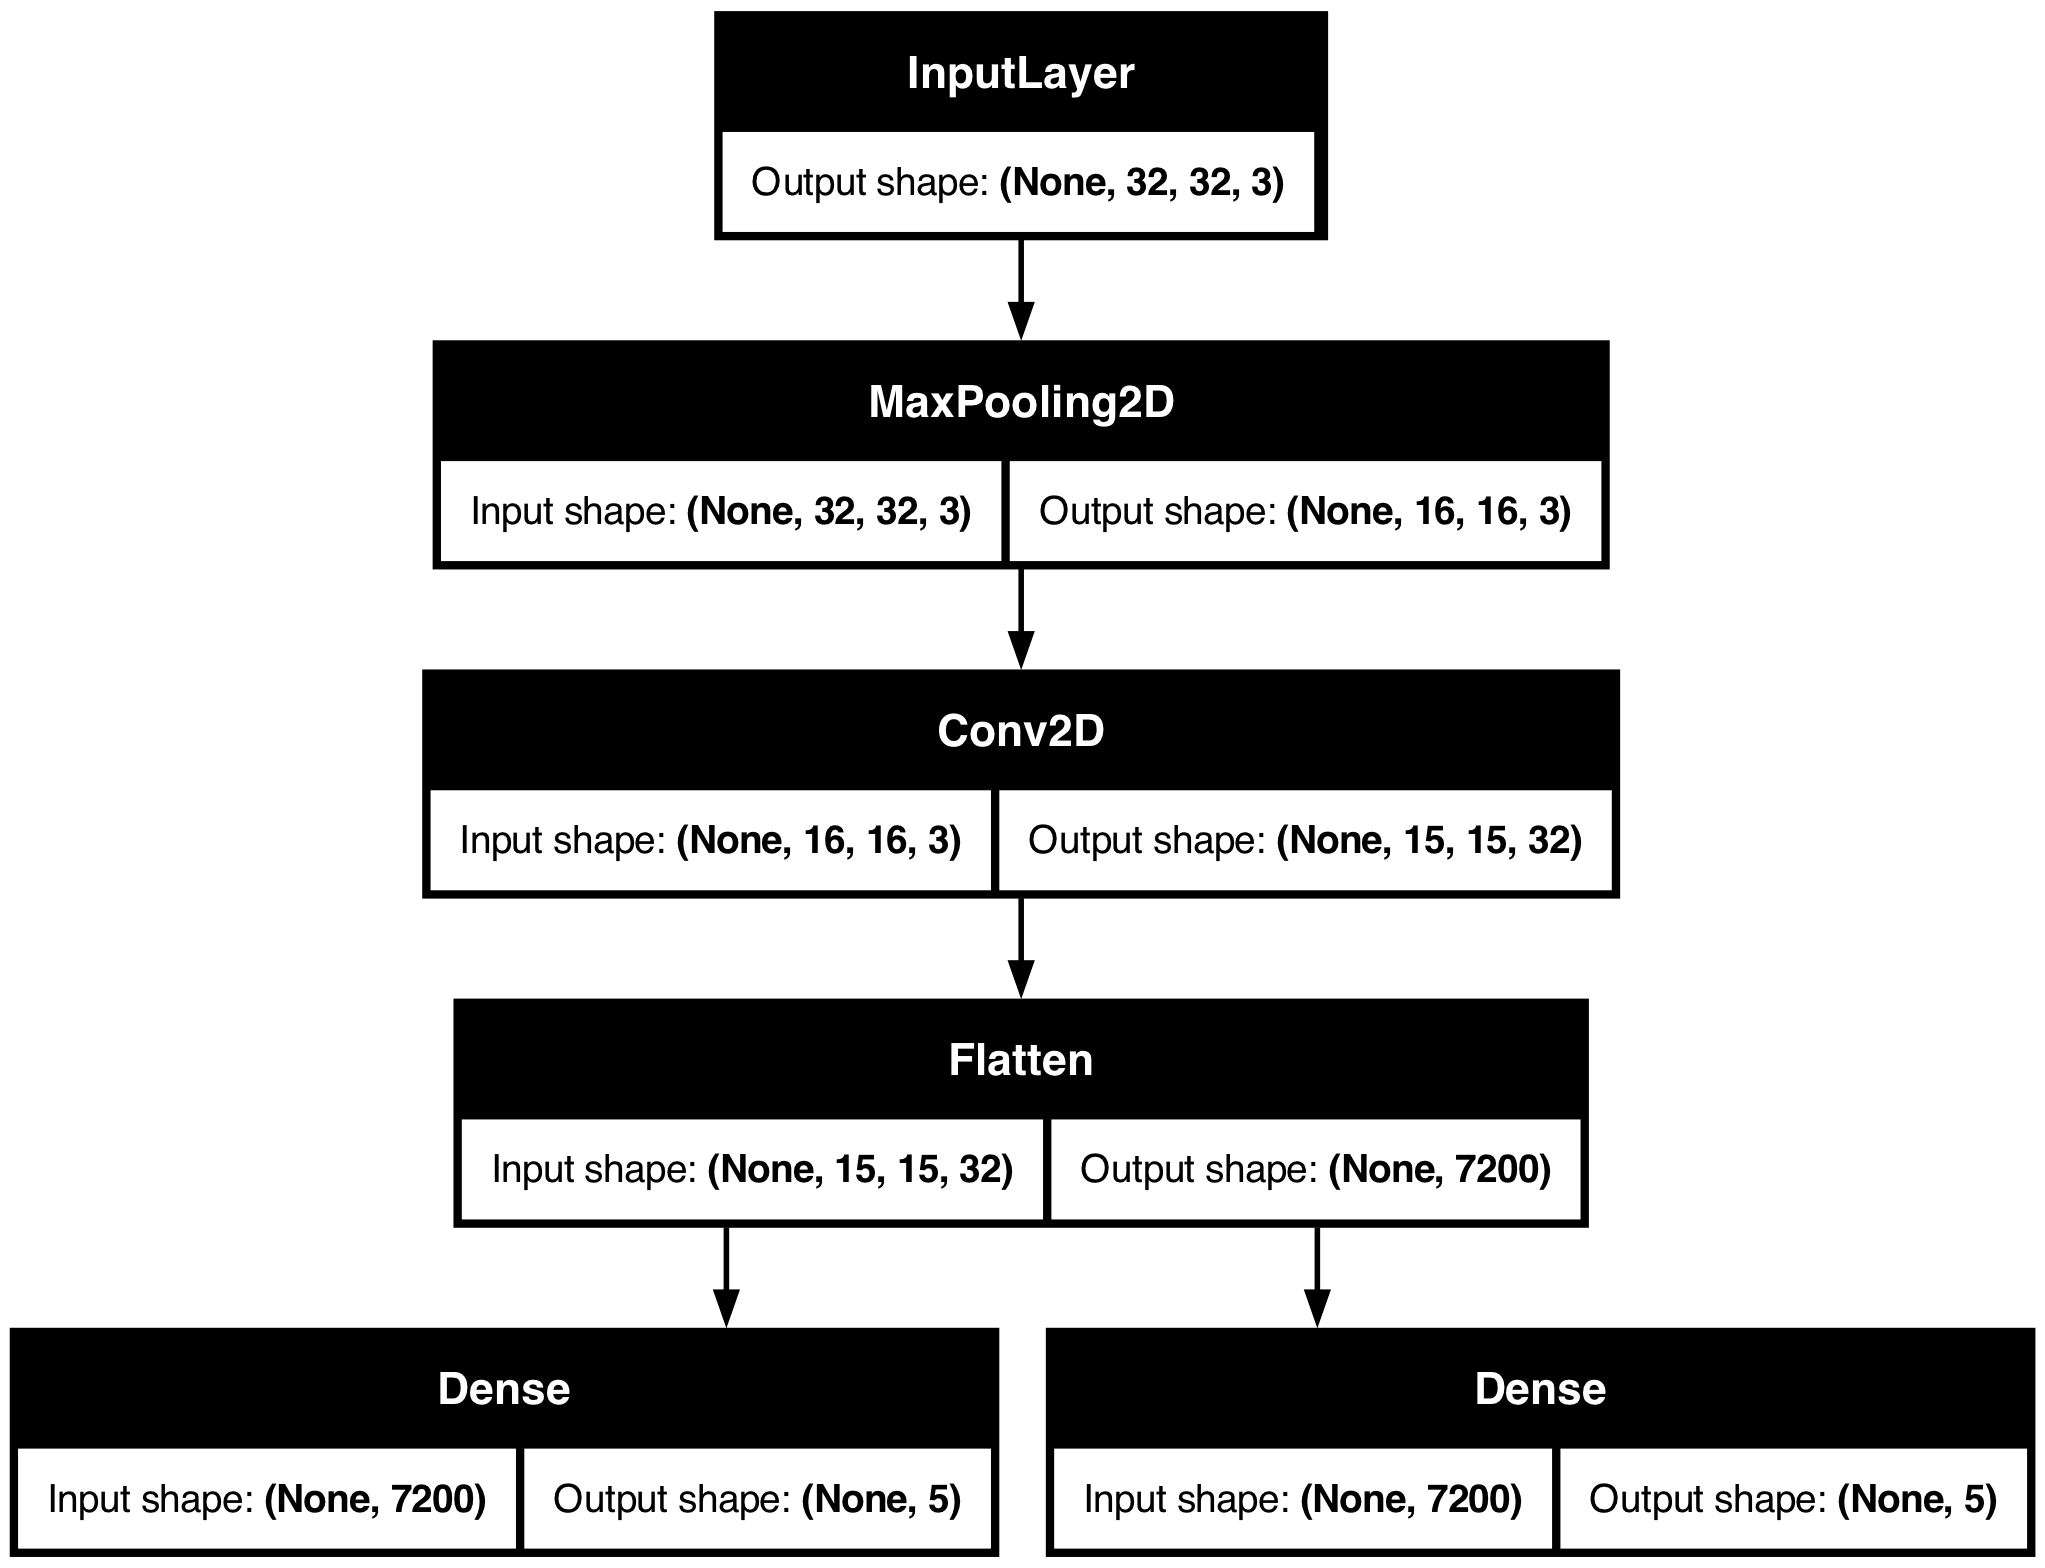

In [211]:
K.clear_session()

inputs = keras.Input(shape=(32,32,3))
pool = layers.MaxPool2D(pool_size=(2,2))(inputs) # 16x16
conv = layers.Conv2D(32, (2, 2), activation=LeakyReLU())(pool) # 15x15
x = layers.Flatten()(conv)
output1 = layers.Dense(5, name='output1')(x)
output2 = layers.Dense(5, name='output2')(x)

model = keras.Model(
    inputs,
    outputs={'output1':output1, 'output2':output2}, name='Toy',
    )
keras.utils.plot_model(model, "toy.png", show_shapes=True)

In [212]:
model.summary()

Model: "Toy"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16, 3) │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 15, 15,    │        416 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7200)      │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │     36,005 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │     36,005 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72,426 (282.91 KB)

 Trainable params: 72,426 (282.91 KB)

 Non-trainable params: 0 (0.00 B)

In [219]:
model.compile(
    optimizer='Adam', 
    loss={'output1':keras.losses.CategoricalCrossentropy(from_logits=True), 'output2':keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={'output1':'accuracy', 'output2':'accuracy'})

history = model.fit(
    traingen,           
    epochs=2,          
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen, 
    validation_steps=len(cifar10_x_val)//batchsize,  
    # callbacks=[val_early_stopping, val_model_checkpoint_callback],  
    verbose=2
)

Epoch 1/2
703/703 - 3s - 5ms/step - loss: 2.5423 - output1_accuracy: 0.4601 - output2_accuracy: 0.5068 - val_loss: 2.5641 - val_output1_accuracy: 0.4545 - val_output2_accuracy: 0.5084
Epoch 2/2
703/703 - 2s - 4ms/step - loss: 2.4828 - output1_accuracy: 0.4726 - output2_accuracy: 0.5258 - val_loss: 2.5371 - val_output1_accuracy: 0.4399 - val_output2_accuracy: 0.5168


Important, I have to add a dictionary entry for my custom layer Leaky ReLU!

In [214]:
model.save('toy.keras')
toy = load_model('toy.keras',custom_objects={"LeakyReLU": LeakyReLU})

"These include adding horizontally flipped examples of all images as well as randomly translated
versions (with a maximum translation of 5 pixels in each dimension). In all experiments images
were whitened and contrast normalized following Goodfellow et al. (2013)" from STRIVING FOR SIMPLICITY:
THE ALL CONVOLUTIONAL NET

((22500)*2)*(6^4) = 58 million examples!

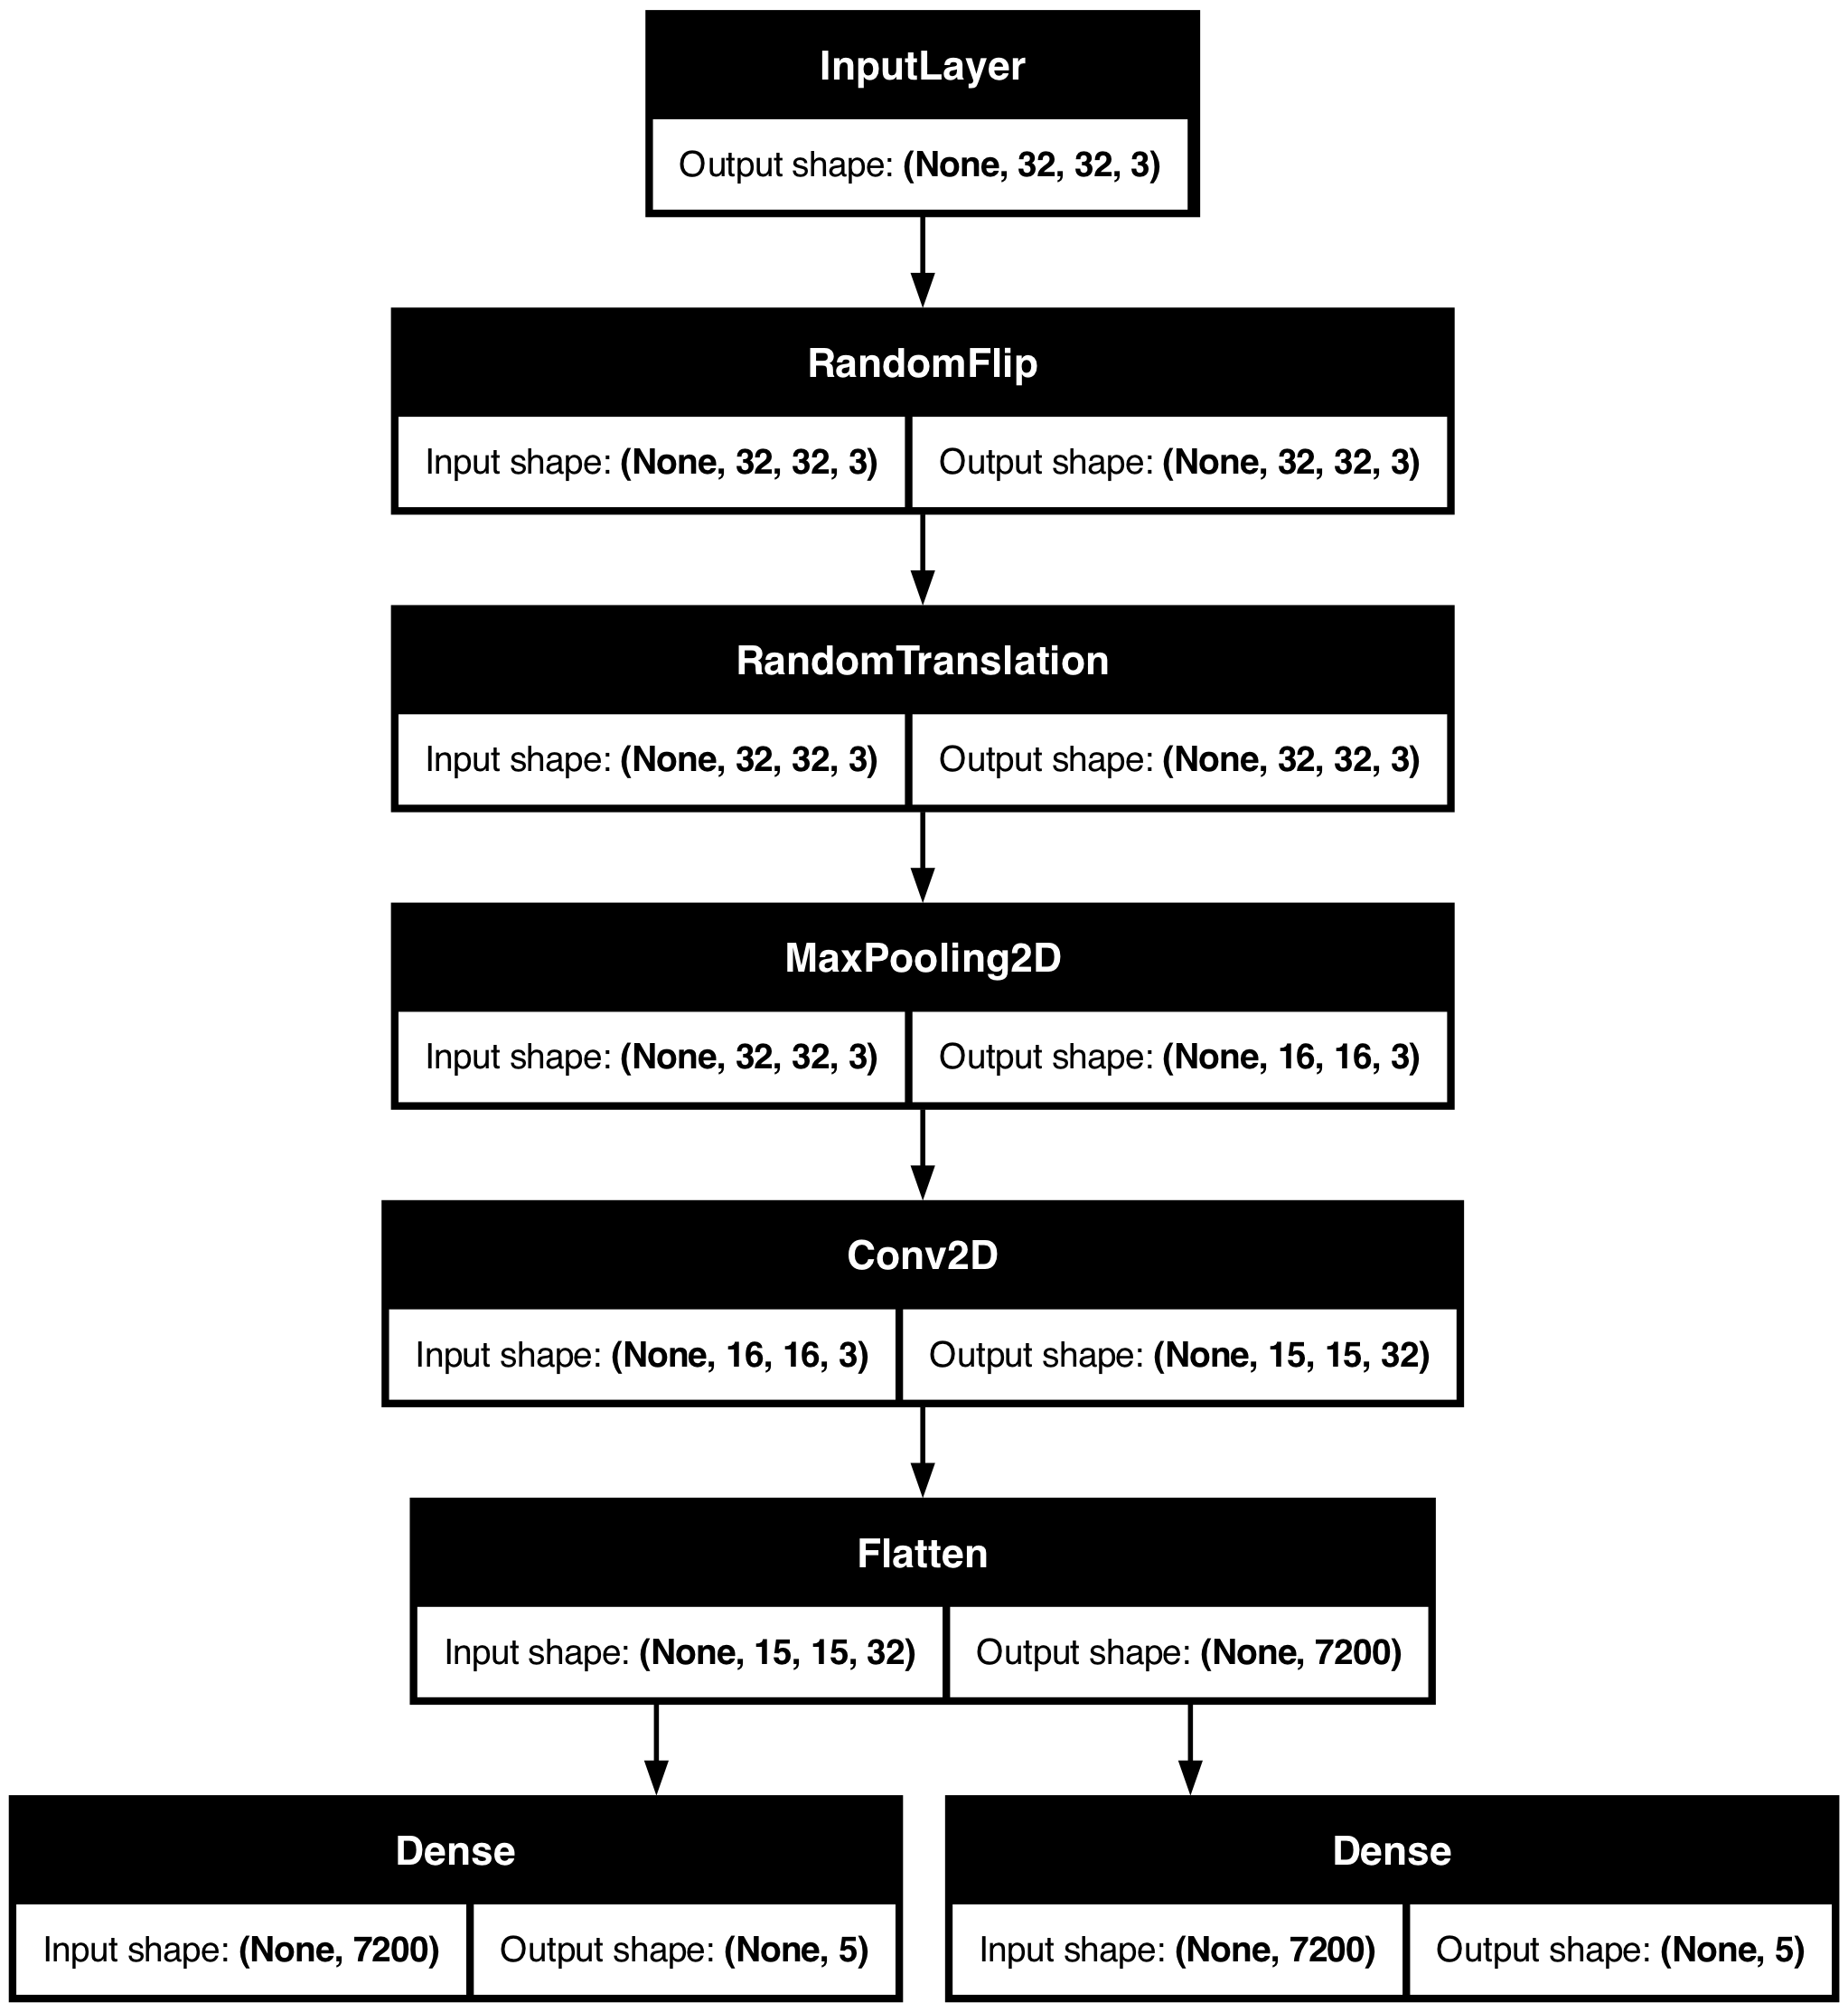

In [ ]:
K.clear_session()
def FMP6():
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Data Augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # Feature Extractor
    pool = layers.MaxPool2D(pool_size=(2,2))(x) # 16x16
    conv = layers.Conv2D(32, (2, 2), activation=LeakyReLU())(pool) # 15x15
    x = layers.Flatten()(conv)
    # Classifiers
    output1 = layers.Dense(5, name='output1')(x)
    output2 = layers.Dense(5, name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='Toy',
        )
    return model

model = FMP6()
keras.utils.plot_model(model, "toy.png", show_shapes=True)

In [236]:
model.compile(
    optimizer='Adam', 
    loss={'output1':keras.losses.CategoricalCrossentropy(from_logits=True), 'output2':keras.losses.CategoricalCrossentropy(from_logits=True)},
    metrics={'output1':'accuracy', 'output2':'accuracy'})

history = model.fit(
    traingen,           
    epochs=2,          
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen, 
    validation_steps=len(cifar10_x_val)//batchsize,  
    # callbacks=[val_early_stopping, val_model_checkpoint_callback],  
    verbose=2
)

Epoch 1/2
703/703 - 4s - 6ms/step - loss: 2.8701 - output1_accuracy: 0.3740 - output2_accuracy: 0.3994 - val_loss: 2.6709 - val_output1_accuracy: 0.4441 - val_output2_accuracy: 0.4679
Epoch 2/2
703/703 - 3s - 5ms/step - loss: 2.7494 - output1_accuracy: 0.4098 - output2_accuracy: 0.4410 - val_loss: 2.6554 - val_output1_accuracy: 0.4277 - val_output2_accuracy: 0.4798


In [246]:
@keras.saving.register_keras_serializable()
class FMP3S(Model):
    def __init__(self):
        super(FMP3S, self).__init__()
        # Input layer size 32x32
        # Data Augmentation
        self.rf = layers.RandomFlip("horizontal")
        # self.rt = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU())
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU())

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Two Classifiers 
        self.fc1 = layers.Dense(5, activation='softmax', name='output1')  # First half
        self.fc2 = layers.Dense(5, activation='softmax', name='output2')  # Second half

    def call(self, inputs):
        # Data Augmentation
        x = self.rf(inputs)
        # x = self.rt(x)

        # Feature Extractor
        x = self.conv1(x) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        # Idea, make the classifier heads deeper or convolutionnally based
        output1 = self.fc1(x)  # First half
        output2 = self.fc2(x)  # Second half

        return {'output1': output1, 'output2': output2}
    
    def get_config(self):
        # Serialize the configuration of the model
        config = super(FMP3S, self).get_config()
        config.update({
            'rf': self.rf.get_config(),
            # 'rt': self.rt.get_config(),
            'conv1': self.conv1.get_config(),
            'conv2': self.conv2.get_config(),
            'conv3': self.conv3.get_config(),
            'conv4': self.conv4.get_config(),
            'conv5': self.conv5.get_config(),
            'conv6': self.conv6.get_config(),
            'conv7': self.conv7.get_config(),
            'conv8': self.conv8.get_config(),
            'dropout': self.dropout.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
            'pooling_ratios': [
                self.pooling_ratio1,
                self.pooling_ratio2,
                self.pooling_ratio3,
                self.pooling_ratio4,
                self.pooling_ratio5,
                self.pooling_ratio6
            ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls()

In [247]:
K.clear_session()
model = FMP3S()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

Model: "fmp3s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output1 (Dense)                 │ ?                      │           965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output2 (Dense)                 │ ?                      │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [248]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./FMP3S/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=2
)

Epoch 1/100

Epoch 1: Average accuracy improved to 0.4156, saving model to ./FMP3S/0.40-0.43-epoch01-loss2.88.keras
703/703 - 70s - 99ms/step - loss: 2.8800 - output1_accuracy: 0.3663 - output2_accuracy: 0.3780 - val_loss: 2.7374 - val_output1_accuracy: 0.4018 - val_output2_accuracy: 0.4293
Epoch 2/100

Epoch 2: Average accuracy improved to 0.4442, saving model to ./FMP3S/0.43-0.46-epoch02-loss2.60.keras
703/703 - 71s - 100ms/step - loss: 2.6002 - output1_accuracy: 0.4315 - output2_accuracy: 0.4856 - val_loss: 2.6324 - val_output1_accuracy: 0.4285 - val_output2_accuracy: 0.4599
Epoch 3/100

Epoch 3: Average accuracy improved to 0.5194, saving model to ./FMP3S/0.47-0.57-epoch03-loss2.42.keras
703/703 - 73s - 104ms/step - loss: 2.4240 - output1_accuracy: 0.4658 - output2_accuracy: 0.5475 - val_loss: 2.3655 - val_output1_accuracy: 0.4730 - val_output2_accuracy: 0.5659
Epoch 4/100

Epoch 4: Average accuracy improved to 0.5306, saving model to ./FMP3S/0.47-0.59-epoch04-loss2.33.keras
703/70

In [249]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, acc2 = model.evaluate(testgen, batch_size=10000, steps=1, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]

mean accuracy =  0.6712249994277955
standard deviation =  0.008714215770584259


In [250]:
@keras.saving.register_keras_serializable()
class FMP3M(Model):
    def __init__(self):
        super(FMP3M, self).__init__()
        # Input layer size 32x32
        # Data Augmentation
        self.rf = layers.RandomFlip("horizontal")
        self.rt = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')

        # Six convolutional layers (C2 layers). Each convolutional layer should have an increasing number of filters, starting from 10n filters.
        self.conv1 = layers.Conv2D(32, (2, 2), activation=LeakyReLU())
        self.conv2 = layers.Conv2D(64, (2, 2), activation=LeakyReLU())
        self.conv3 = layers.Conv2D(96, (2, 2), activation=LeakyReLU())
        self.conv4 = layers.Conv2D(128, (2, 2), activation=LeakyReLU())
        self.conv5 = layers.Conv2D(160, (2, 2), activation=LeakyReLU())
        self.conv6 = layers.Conv2D(192, (2, 2), activation=LeakyReLU())

        # Six fractional max pooling layers
        self.pooling_ratio1 = [1.0, 31/22, 31/22, 1.0]
        self.pooling_ratio2 = [1.0, 21/15, 21/15, 1.0]
        self.pooling_ratio3 = [1.0, 14/10, 14/10, 1.0]
        self.pooling_ratio4 = [1.0, 9/6, 9/6, 1.0]
        self.pooling_ratio5 = [1.0, 5/4, 5/4, 1.0]
        self.pooling_ratio6 = [1.0, 3/2, 3/2, 1.0]

        # Two final convolutional layers
        self.conv7 = layers.Conv2D(192, (2, 2), activation=LeakyReLU()) # 4x4
        self.conv8 = layers.Conv2D(192, (1, 1), activation=LeakyReLU())

        # Linearly increasing dropout in the hidden layers
        self.dropout = layers.Dropout(0.5)  # 50% dropout in the final hidden layer

        # Two Classifiers 
        self.fc1 = layers.Dense(5, activation='softmax', name='output1')  # First half
        self.fc2 = layers.Dense(5, activation='softmax', name='output2')  # Second half

    def call(self, inputs):
        # Data Augmentation
        x = self.rf(inputs)
        x = self.rt(x)

        # Feature Extractor
        x = self.conv1(x) # 31x31
        x, _, _ = fractional_max_pool(x, self.pooling_ratio1, pseudo_random=True, overlapping=True) # 22x22
        x = self.conv2(x) # 21x21
        x, _, _ = fractional_max_pool(x, self.pooling_ratio2, pseudo_random=True, overlapping=True) # 15x15
        x = self.conv3(x) # 14x14
        x, _, _ = fractional_max_pool(x, self.pooling_ratio3, pseudo_random=True, overlapping=True) # 10x10
        x = self.conv4(x) # 9x9
        x, _, _ = fractional_max_pool(x, self.pooling_ratio4, pseudo_random=True, overlapping=True) # 6x6
        x = self.conv5(x) #5x5
        x, _, _ = fractional_max_pool(x, self.pooling_ratio5, pseudo_random=True, overlapping=True) # 4x4
        x = self.conv6(x) # 3x3
        x, _, _ = fractional_max_pool(x, self.pooling_ratio6, pseudo_random=True, overlapping=True) # 2x2
        x = self.conv7(x) # 1x1
        x = self.conv8(x) #1x1

        # Classifier
        x = layers.Flatten()(x) # future improvement might be to use global average pooling to lower the FCN parameter count
        x = self.dropout(x)
        # Idea, make the classifier heads deeper or convolutionnally based
        output1 = self.fc1(x)  # First half
        output2 = self.fc2(x)  # Second half

        return {'output1': output1, 'output2': output2}
    
    def get_config(self):
        # Serialize the configuration of the model
        config = super(FMP3S, self).get_config()
        config.update({
            'rf': self.rf.get_config(),
            'rt': self.rt.get_config(),
            'conv1': self.conv1.get_config(),
            'conv2': self.conv2.get_config(),
            'conv3': self.conv3.get_config(),
            'conv4': self.conv4.get_config(),
            'conv5': self.conv5.get_config(),
            'conv6': self.conv6.get_config(),
            'conv7': self.conv7.get_config(),
            'conv8': self.conv8.get_config(),
            'dropout': self.dropout.get_config(),
            'fc1': self.fc1.get_config(),
            'fc2': self.fc2.get_config(),
            'pooling_ratios': [
                self.pooling_ratio1,
                self.pooling_ratio2,
                self.pooling_ratio3,
                self.pooling_ratio4,
                self.pooling_ratio5,
                self.pooling_ratio6
            ]
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls()
    
    K.clear_session()
model = FMP3M()
model.build(input_shape=(None, 32, 32, 3))
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
model(tf.random.normal((1, 32, 32, 3)))
model.summary()

val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./FMP3M/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)

history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=2
)

/opt/homebrew/lib/python3.9/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'fmp3m', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "fmp3m"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ ?                      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │        24,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │        82,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │       123,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output1 (Dense)                 │ ?                      │           965 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output2 (Dense)                 │ ?                      │           965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,410 (1.81 MB)

 Trainable params: 474,410 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100

Epoch 1: Average accuracy improved to 0.4087, saving model to ./FMP3M/0.41-0.41-epoch01-loss2.93.keras


TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, acc2 = model.evaluate(testgen, batch_size=10000, steps=1, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

In [ ]:
filepath = ''
evaluate_model(filepath, testgen, repeat=10)

K.clear_session()
def FMP6():
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Data Augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # Feature Extractor
    pool = layers.MaxPool2D(pool_size=(2,2))(x) # 16x16
    conv = layers.Conv2D(32, (2, 2), activation=LeakyReLU())(pool) # 15x15
    x = layers.Flatten()(conv)
    # Classifiers
    output1 = layers.Dense(5, name='output1')(x)
    output2 = layers.Dense(5, name='output2')(x)
    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='Toy',
        )
    return model

model = FMP6()
keras.utils.plot_model(model, "toy.png", show_shapes=True)

In [ ]:
def ACCN():
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Data Augmentation
    # x = layers.RandomFlip("horizontal")(x)
    # x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # x = layers.Normalization()(x)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    print(x.shape)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    print(x.shape)
    # Classifers
    x1 = layers.Conv2D(5, (2,2), activation='relu')(x)
    print(x1.shape)
    x1 = layers.GlobalAveragePooling2D()(x1)
    print(x1.shape)
    output1 = layers.Activation('softmax', name='output1')(x1)
    print(output1.shape)
    x2 = layers.Conv2D(5, (2,2), activation='relu')(x)
    x2 = layers.GlobalAveragePooling2D()(x2)
    output2 = layers.Activation('softmax', name='output2')(x2)

    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN',
        )
    return model

K.clear_session()
model = ACCN()
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
keras.utils.plot_model(model, show_shapes=True, dpi=50)

(None, 4, 4, 192)
(None, 2, 2, 192)
(None, 1, 1, 5)
(None, 5)
(None, 5)


In [272]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./ACNN/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

# val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
#                                patience=10,         # Number of epochs to wait after the last improvement
#                                mode='min',         # Stop when the value stops decreasing (minimization)
#                                restore_best_weights=True,  # Restore the best weights when stopping
#                                verbose=1)
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=2
)

Epoch 1/100

Epoch 1: Average accuracy improved to 0.1929, saving model to ./ACNN/0.19-0.20-epoch01-loss3.22.keras


FileNotFoundError: [Errno 2] No such file or directory: './ACNN/0.19-0.20-epoch01-loss3.22.keras'

In [15]:
def ACCN():
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Data Augmentation
    # x = layers.RandomFlip("horizontal")(x)
    # x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # x = layers.Normalization()(x)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    print(x.shape)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    print(x.shape)
    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)

    # # Feature Extractor
    # x = layers.Conv2D(96, (3,3), activation='relu')(inputs

    # x1 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # print(x1.shape)
    # x1 = layers.GlobalAveragePooling2D()(x1)
    # print(x1.shape)
    # output1 = layers.Activation('softmax', name='output1')(x1)
    # print(output1.shape)
    # x2 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # x2 = layers.GlobalAveragePooling2D()(x2)
    # output2 = layers.Activation('softmax', name='output2')(x2)

    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN',
        )
    return model

K.clear_session()
model = ACCN()
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
keras.utils.plot_model(model, show_shapes=True, dpi=50)

(None, 4, 4, 192)
(None, 2, 2, 192)
You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./ACNN/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ conv2d_2[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,126,496 (15.74 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,750,998 (10.49 MB)

Epoch 1/100
699/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4482 - output1_accuracy: 0.6692 - output1_loss: 0.8353 - output2_accuracy: 0.7706 - output2_loss: 0.6130
Epoch 1: Average accuracy improved to 0.6767, saving model to ./ACNN/0.63-0.73-epoch01-loss1.45.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1.4482 - output1_accuracy: 0.6692 - output1_loss: 0.8353 - output2_accuracy: 0.7707 - output2_loss: 0.6129 - val_loss: 1.6807 - val_output1_accuracy: 0.6282 - val_output1_loss: 0.9497 - val_output2_accuracy: 0.7252 - val_output2_loss: 0.7310
Epoch 2/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4377 - output1_accuracy: 0.6717 - output1_loss: 0.8302 - output2_accuracy: 0.7725 - output2_loss: 0.6075
Epoch 2: Average accuracy improved to 0.6821, saving model to ./ACNN/0.63-0.73-epoch02-loss1.44.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1.4377 - output1_accuracy: 0.6717 - output1_loss: 0.8302 - output2_accuracy: 0.7725 - output2_loss: 0.6075 - val_los

In [19]:
testgensmall = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1000)

In [33]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:05<00:00,  1.83it/s]

mean accuracy =  0.7936863243579865
standard deviation =  0.003479763093993383


In [22]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

mean accuracy =  0.7924940764904023
standard deviation =  0.0025116521517537503


In [30]:
model.save('test2.keras')

There is a small problem with my save checkpoint which does not save the best one...

In [31]:
def evaluate_model(filepath, gen, repeat=1, steps=1):
    model = load_model(filepath)
    evaluation_results = []
    for i in tqdm(range(repeat)):
        loss, acc1, loss1, acc2, loss2 = model.evaluate(gen, batch_size=10000, steps=steps, verbose=False)
        evaluation_results.append(np.mean([acc1, acc2]))
    print("mean accuracy = ", np.mean(evaluation_results))
    print("standard deviation = ", np.std(evaluation_results))

evaluate_model('test2.keras', testgensmall, repeat=10, steps=10)

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]

mean accuracy =  0.7925562739372254
standard deviation =  0.0033339649525372422


In [36]:
def ACCN1(): # Adds dropout
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Dropout(0.2)
    # Data Augmentation
    # x = layers.RandomFlip("horizontal")(x)
    # x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # x = layers.Normalization()(x)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)

    # # Feature Extractor
    # x = layers.Conv2D(96, (3,3), activation='relu')(inputs

    # x1 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # print(x1.shape)
    # x1 = layers.GlobalAveragePooling2D()(x1)
    # print(x1.shape)
    # output1 = layers.Activation('softmax', name='output1')(x1)
    # print(output1.shape)
    # x2 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # x2 = layers.GlobalAveragePooling2D()(x2)
    # output2 = layers.Activation('softmax', name='output2')(x2)

    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN1',
        )
    return model

K.clear_session()
model = ACCN1()
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
keras.utils.plot_model(model, show_shapes=True, dpi=50)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [37]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./ACNN1/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout_1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,498 (5.25 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
700/703 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0758 - output1_accuracy: 0.2917 - output1_loss: 1.5433 - output2_accuracy: 0.2959 - output2_loss: 1.5325
Epoch 1: Average accuracy improved to 0.3775, saving model to ./ACNN1/0.37-0.39-epoch01-loss2.99.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 3.0753 - output1_accuracy: 0.2919 - output1_loss: 1.5430 - output2_accuracy: 0.2961 - output2_loss: 1.5323 - val_loss: 2.8521 - val_output1_accuracy: 0.3700 - val_output1_loss: 1.4207 - val_output2_accuracy: 0.3850 - val_output2_loss: 1.4315
Epoch 2/100
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8123 - output1_accuracy: 0.3900 - output1_loss: 1.4029 - output2_accuracy: 0.3926 - output2_loss: 1.4094
Epoch 2: Average accuracy improved to 0.4268, saving model to ./ACNN1/0.41-0.44-epoch02-loss2.76.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 2.8121 - output1_accuracy: 0.3900 - output1_loss: 1.4028 - output2_accuracy: 0.3926 - output2_loss: 1.4093 - val_

In [42]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

mean accuracy =  0.8077306419610977
standard deviation =  0.002342914916912416


In [41]:
model.save('ACCN1-80.6.keras')

In [45]:
ACCN180 = load_model('ACCN1-80.6.keras')
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = ACCN180.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

mean accuracy =  0.8078694552183151
standard deviation =  0.0028045642861268295


In [48]:
def ACCN2(): # Adds data augmentation
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    # Data Augmentation
    x = layers.RandomFlip("horizontal")(inputs)
    # x = layers.Dropout(0.2)(x) # removed after unable to train
    # x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # x = layers.Normalization()(x)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)

    # # Feature Extractor
    # x = layers.Conv2D(96, (3,3), activation='relu')(inputs

    # x1 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # print(x1.shape)
    # x1 = layers.GlobalAveragePooling2D()(x1)
    # print(x1.shape)
    # output1 = layers.Activation('softmax', name='output1')(x1)
    # print(output1.shape)
    # x2 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # x2 = layers.GlobalAveragePooling2D()(x2)
    # output2 = layers.Activation('softmax', name='output2')(x2)

    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN2',
        )
    return model

K.clear_session()
model = ACCN2()
model.compile(optimizer='adam',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
keras.utils.plot_model(model, show_shapes=True, dpi=50)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [49]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./ACNN2/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout[0][0]     │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,498 (5.25 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


699/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0626 - output1_accuracy: 0.2891 - output1_loss: 1.5358 - output2_accuracy: 0.2974 - output2_loss: 1.5268
Epoch 1: Average accuracy improved to 0.3861, saving model to ./ACNN2/0.37-0.40-epoch01-loss2.95.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 3.0618 - output1_accuracy: 0.2894 - output1_loss: 1.5354 - output2_accuracy: 0.2977 - output2_loss: 1.5264 - val_loss: 2.8076 - val_output1_accuracy: 0.3720 - val_output1_loss: 1.4096 - val_output2_accuracy: 0.4002 - val_output2_loss: 1.3981
Epoch 2/100
700/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7777 - output1_accuracy: 0.3954 - output1_loss: 1.3996 - output2_accuracy: 0.4173 - output2_loss: 1.3782
Epoch 2: Average accuracy improved to 0.4502, saving model to ./ACNN2/0.43-0.47-epoch02-loss2.73.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.7775 - output1_accuracy: 0.3955 - output1_loss: 1.3995 - output2_accuracy: 0.4174 - output2_loss: 1.3780 - val_loss: 2.6215

In [50]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

mean accuracy =  0.7978636801242829
standard deviation =  0.002850393049580842


Need to fine tune without random somehow...

In [5]:
def ACCN3(): # Adds dropout
    # Input CIFAR-10
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Dropout(0.2)
    # Data Augmentation
    # x = layers.RandomFlip("horizontal")(x)
    # x = layers.RandomTranslation(height_factor=5/32, width_factor=5/32, fill_mode='nearest')(x)
    # x = layers.Normalization()(x)
    # Feature Extractor
    x = layers.Conv2D(96, (3,3), activation='relu')(inputs)
    x = layers.Conv2D(96, (3,3), activation='relu')(x)
    x = layers.Conv2D(96, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (3,3), activation='relu', strides=2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(192, (3,3), activation='relu')(x)
    x = layers.Conv2D(192, (1,1), activation='relu')(x)
    # Classifers
    x = layers.Flatten()(x)
    output1 = layers.Dense(5, activation='softmax', name='output1')(x)
    output2 = layers.Dense(5, activation='softmax', name='output2')(x)

    # # Feature Extractor
    # x = layers.Conv2D(96, (3,3), activation='relu')(inputs

    # x1 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # print(x1.shape)
    # x1 = layers.GlobalAveragePooling2D()(x1)
    # print(x1.shape)
    # output1 = layers.Activation('softmax', name='output1')(x1)
    # print(output1.shape)
    # x2 = layers.Conv2D(5, (2,2), activation='relu')(x)
    # x2 = layers.GlobalAveragePooling2D()(x2)
    # output2 = layers.Activation('softmax', name='output2')(x2)

    # Model creation
    model = keras.Model(
        inputs,
        outputs={'output1':output1, 'output2':output2}, name='ACCN3',
        )
    return model

K.clear_session()
model = ACCN3()
model.compile(optimizer='adagrad',
              loss={'output1': 'categorical_crossentropy', 'output2': 'categorical_crossentropy'},
              metrics={'output1': 'accuracy', 'output2': 'accuracy'})
keras.utils.plot_model(model, show_shapes=True, dpi=50)

I0000 00:00:1736615949.920146   17527 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13499 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:0a:00.0, compute capability: 8.9


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [52]:
val_model_checkpoint_callback = MeanAccModelCheckpoint(
    filepath="./ACNN3/{output1_accuracy:.2f}-{output2_accuracy:.2f}-epoch{epoch:02d}-loss{loss:.2f}.keras",
    monitor1='val_output1_accuracy',
    monitor2='val_output2_accuracy',
    verbose=1
)

val_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',  # Track the validation loss
                               patience=10,         # Number of epochs to wait after the last improvement
                               mode='min',         # Stop when the value stops decreasing (minimization)
                               restore_best_weights=True,  # Restore the best weights when stopping
                               verbose=1)
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout_1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,498 (5.25 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
702/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2188 - output1_accuracy: 0.2086 - output1_loss: 1.6095 - output2_accuracy: 0.2095 - output2_loss: 1.6093
Epoch 1: Average accuracy improved to 0.2490, saving model to ./ACNN3/0.24-0.25-epoch01-loss3.22.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 3.2188 - output1_accuracy: 0.2086 - output1_loss: 1.6095 - output2_accuracy: 0.2095 - output2_loss: 1.6093 - val_loss: 3.2170 - val_output1_accuracy: 0.2444 - val_output1_loss: 1.6089 - val_output2_accuracy: 0.2536 - val_output2_loss: 1.6081
Epoch 2/100
698/703 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2169 - output1_accuracy: 0.2372 - output1_loss: 1.6087 - output2_accuracy: 0.2498 - output2_loss: 1.6082
Epoch 2: Average accuracy improved to 0.2904, saving model to ./ACNN3/0.27-0.31-epoch02-loss3.22.keras
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 3.2169 - output1_accuracy: 0.2372 - output1_loss: 1.6087 - output2_accuracy: 0.2499 - output2_loss: 1.6082 - val_

In [53]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

mean accuracy =  0.8551178485155105
standard deviation =  0.002060303693756444


In [54]:
model.save('ACNN3-85.5.keras')

In [57]:
ACCN3 = load_model('ACNN3-85.5.keras')
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = ACCN3.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

mean accuracy =  0.8558160707354545
standard deviation =  0.0031677117740428074


In [58]:
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout_1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,750,998 (10.49 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,375,500 (5.25 MB)

Epoch 1/100
700/703 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3531 - output1_accuracy: 0.4956 - output1_loss: 1.2195 - output2_accuracy: 0.5448 - output2_loss: 1.1335
Epoch 1: Average accuracy did not improve (current: 0.5233, best: 0.5331)
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3531 - output1_accuracy: 0.4956 - output1_loss: 1.2195 - output2_accuracy: 0.5448 - output2_loss: 1.1336 - val_loss: 2.3300 - val_output1_accuracy: 0.4906 - val_output1_loss: 1.2147 - val_output2_accuracy: 0.5561 - val_output2_loss: 1.1153
Epoch 2/100
701/703 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3490 - output1_accuracy: 0.5079 - output1_loss: 1.2009 - output2_accuracy: 0.5393 - output2_loss: 1.1481
Epoch 2: Average accuracy did not improve (current: 0.5246, best: 0.5331)
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3491 - output1_accuracy: 0.5078 - output1_loss: 1.2009 - output2_accuracy: 0.5393 - output2_loss: 1.1481 - val_loss: 2.3400 - val_output1_accuracy: 0.4928 - val_output1_l

In [59]:
evaluation_results = []
for i in tqdm(range(10)):
    loss, acc1, loss1, acc2, loss2 = model.evaluate(testgensmall, batch_size=1000, steps=10, verbose=False)
    evaluation_results.append(np.mean([acc1, acc2]))
print("mean accuracy = ", np.mean(evaluation_results))
print("standard deviation = ", np.std(evaluation_results))

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

mean accuracy =  0.8476039469242096
standard deviation =  0.002697744617377782


In [7]:
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=50,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    # callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout_1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,750,998 (10.49 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,375,500 (5.25 MB)

Epoch 1/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.4843 - output1_accuracy: 0.4787 - output1_loss: 1.2502 - output2_accuracy: 0.4968 - output2_loss: 1.2341 - val_loss: 2.4948 - val_output1_accuracy: 0.4708 - val_output1_loss: 1.2724 - val_output2_accuracy: 0.5024 - val_output2_loss: 1.2224
Epoch 2/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.4939 - output1_accuracy: 0.4732 - output1_loss: 1.2644 - output2_accuracy: 0.4912 - output2_loss: 1.2296 - val_loss: 2.4797 - val_output1_accuracy: 0.4768 - val_output1_loss: 1.2599 - val_output2_accuracy: 0.5010 - val_output2_loss: 1.2198
Epoch 3/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 2.4852 - output1_accuracy: 0.4734 - output1_loss: 1.2606 - output2_accuracy: 0.5010 - output2_loss: 1.2246 - val_loss: 2.4748 - val_output1_accuracy: 0.4665 - val_output1_loss: 1.2629 - val_output2_accuracy: 0.5058 - val_output2_loss: 1.2119
Epoch 4/50
703/703 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.4816 - output1_accuracy: 0.

In [8]:
model.summary()
history = model.fit(
    traingen,            # Training data generator
    epochs=100,          # Number of epochs to train
    steps_per_epoch=len(cifar10_x_train)//batchsize,
    validation_data=valgen,  # Validation data generator
    validation_steps=len(cifar10_x_val)//batchsize,  # Steps per validation epoch (if using a generator)
    # callbacks=[val_early_stopping, val_model_checkpoint_callback],  # Early stopping callback
    verbose=1
)

Model: "ACCN3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     83,040 │ conv2d[0][0]      │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     83,040 │ conv2d_1[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 13,    │          0 │ conv2d_2[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 11, 11,    │    166,080 │ dropout_1[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 9, 9, 192) │    331,968 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    331,968 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 4, 192) │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 2, 2, 192) │    331,968 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 2, 2, 192) │     37,056 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output1 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output2 (Dense)     │ (None, 5)         │      3,845 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,750,998 (10.49 MB)

 Trainable params: 1,375,498 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,375,500 (5.25 MB)

Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3523 - output1_accuracy: 0.4991 - output1_loss: 1.2048 - output2_accuracy: 0.5351 - output2_loss: 1.1474 - val_loss: 2.3706 - val_output1_accuracy: 0.4898 - val_output1_loss: 1.2364 - val_output2_accuracy: 0.5493 - val_output2_loss: 1.1342
Epoch 2/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3364 - output1_accuracy: 0.5025 - output1_loss: 1.2107 - output2_accuracy: 0.5453 - output2_loss: 1.1257 - val_loss: 2.3529 - val_output1_accuracy: 0.4948 - val_output1_loss: 1.2242 - val_output2_accuracy: 0.5503 - val_output2_loss: 1.1286
Epoch 3/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3211 - output1_accuracy: 0.5090 - output1_loss: 1.1996 - output2_accuracy: 0.5534 - output2_loss: 1.1215 - val_loss: 2.3393 - val_output1_accuracy: 0.4954 - val_output1_loss: 1.2202 - val_output2_accuracy: 0.5549 - val_output2_loss: 1.1191
Epoch 4/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3492 - output1_accuracy:

In [10]:
model.save('ACNN3-200epochs-60acc.keras')